In [21]:
#from google.colab import files
#uploaded = files.upload()

In [49]:
import numpy as np
import pandas as pd
from tqdm import tqdm
from matplotlib import style
import matplotlib.pyplot as plt
import random
import torch
from torch.autograd import Variable
import torch.nn.functional as F
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
import pickle
import copy
style.use("ggplot")

def plot(train_rolling_loss,dev_rolling_loss,train_rolling_acc,dev_rolling_acc):
    plt.figure(figsize=(15,10))
    plt.subplot(221)
    plt.plot(train_rolling_loss,label="training")
    plt.plot(dev_rolling_loss,label="dev")
    plt.title("Rolling Loss",loc='center')
    plt.legend(loc=1)
    plt.subplot(222)
    plt.plot(train_rolling_acc,label="training")
    plt.plot(dev_rolling_acc,label="dev")
    plt.title("Rolling Accuracy",loc='center')
    plt.legend(loc=0)
    plt.show()

In [50]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
torch.cuda.device_count()
torch.cuda.is_available()

False

# 1. Pre-process dataset

In [97]:
## reading clean data
raw = pd.read_csv('cleaned-16-Oct.csv')
raw = raw.drop(['oppo_busi','fac_oppo', 'oppo_Industry'],axis=1)
raw.describe()

,StageName,Parent_Opportunity__c,Is_External__c,ParentId,tasks_events,CreatedYear,CreatedMonth,days,RN,f_won_before
count,5408.000000,5408.000000,5408.000000,5408.000000,5408.000000,5408.000000,5408.00000,5408.000000,5408.00000,5408.000000
mean,0.373706,0.098743,0.992604,0.162722,0.063609,2017.855954,6.32304,470.180288,23.11372,0.457101
std,0.483832,0.298344,0.085692,0.369146,0.244079,1.308152,3.19268,519.571149,49.01797,0.498202
min,0.000000,0.000000,0.000000,0.000000,0.000000,2015.000000,1.00000,-426.000000,1.00000,0.000000
25%,0.000000,0.000000,1.000000,0.000000,0.000000,2017.000000,4.00000,87.000000,1.00000,0.000000
50%,0.000000,0.000000,1.000000,0.000000,0.000000,2018.000000,6.00000,333.000000,2.00000,0.000000
75%,1.000000,0.000000,1.000000,0.000000,0.000000,2019.000000,9.00000,826.000000,15.00000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,2020.000000,12.00000,11618.000000,279.00000,1.000000


In [94]:
raw["StageName"].value_counts(dropna=False)

0    3387
1    2021
Name: StageName, dtype: int64

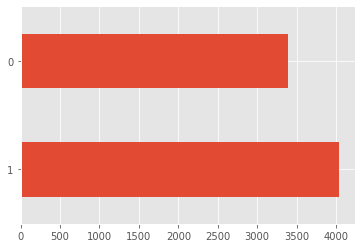

In [95]:
data = pd.concat([raw, raw[raw["StageName"]==1]], axis=0, ignore_index=True)
data["StageName"].value_counts(dropna=False).plot(kind="barh")
from sklearn.utils import shuffle
data = shuffle(data)

## 1.2 One-Hot-Encoding

In [99]:
## one-hot-encoding

a = pd.get_dummies(data["RecordType.Name"], prefix='RecordType')
b = pd.get_dummies(data["RICE_Supported__c"], prefix='RICE_Supported')
c = pd.get_dummies(data["Lead_Faculty__c"], prefix='Lead_Faculty')
d = pd.get_dummies(data["Lead_School__c"], prefix='Lead_School')
e = pd.get_dummies(data["Industry"], prefix='Industry')
f = pd.get_dummies(data["Industry_Sub_Type__c"], prefix='Industry_Sub')
g = pd.get_dummies(data["Business_Type__c"], prefix='Business')

org = data[["StageName","Parent_Opportunity__c","Is_External__c","ParentId","f_won_before"]]

scale3 = data["CreatedYear"].div(2020)
scale4 = data["CreatedMonth"].div(12)
scale5 = data["days"].div(11618)
scale6 = data["RN"].div(279)

#df = pd.concat([org,scale3,scale4,scale5,scale6,a,b,c,d,e,f,g], axis=1, ignore_index=True)
df = pd.concat([org,scale3,scale4,scale5,scale6], axis=1, ignore_index=True)
df

,0,1,2,3,4,5,6,7,8
3998,1,0,1,0,1,0.998515,1.000000,0.058702,0.039427
5794,1,0,1,0,0,0.998515,0.666667,0.068773,0.003584
98,0,0,1,0,0,0.999010,0.583333,0.003873,0.003584
2743,0,0,1,0,0,0.999505,0.833333,0.000861,0.003584
2320,0,0,1,1,1,0.999505,0.250000,0.004390,0.046595
...,...,...,...,...,...,...,...,...,...
5817,1,0,1,0,0,0.998020,0.416667,0.108194,0.003584
1496,0,0,1,0,0,0.999505,0.416667,0.020658,0.003584
2802,0,0,1,0,0,0.999010,0.250000,0.050697,0.003584
6508,1,1,1,0,1,0.999505,0.666667,0.014288,0.007168


In [100]:
# split xy
x = torch.Tensor([i[1:] for i in df.values.tolist()])
y = torch.Tensor([i[0] for i in df.values.tolist()])

# train/dev split
batch_size = 64+16
x_train, x_dev, y_train, y_dev = train_test_split(x, y, test_size=0.33, random_state=42)
train_loader = torch.utils.data.DataLoader(dataset=tuple(zip(x_train,y_train)), batch_size=batch_size, shuffle=True)
dev_loader = torch.utils.data.DataLoader(dataset=tuple(zip(x_dev,y_dev)), batch_size=batch_size, shuffle=True)

In [101]:
n_features, n_classes = int(x_train.shape[1]), 1

# 2. Neural Network Model

In [110]:
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score

class Net(torch.nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        self.linear1 = torch.nn.Linear(n_features,1024)
        self.linear2 = torch.nn.Linear(1024, 1024)
        self.linear3 = torch.nn.Linear(1024, 1024)
        self.linear4 = torch.nn.Linear(1024, 1024)
        self.linear5 = torch.nn.Linear(1024, 1024)
        self.linear6 = torch.nn.Linear(1024, 1024)
        self.linear7 = torch.nn.Linear(1024, n_classes)

    def forward(self, x):
        x = F.relu(self.linear1(x))
        x = F.relu(self.linear2(x))
        x = F.relu(self.linear3(x))
        x = F.relu(self.linear4(x))
        x = F.relu(self.linear5(x))
        x = F.relu(self.linear6(x))
        x = F.relu(self.linear7(x))
        return x
    
def eval_metrics(raw_output,labels):
    outputs = torch.round(torch.sigmoid(raw_output)).detach()
    
    target_true = torch.sum(labels == 1).float()
    predicted_true = torch.sum(outputs).float()
    correct_true = torch.sum(labels * outputs).float()
    
    accuracy = torch.mean(torch.eq(outputs, labels).float()).item()
    precision = correct_true / (predicted_true)
    recall = correct_true / target_true
    
    return accuracy, precision.cpu().item(), recall.cpu().item()


def eval_metrics(raw_output,labels):
    outputs = torch.round(torch.sigmoid(raw_output)).detach()
    accuracy = accuracy_score(labels.detach().numpy(), outputs.numpy())
    precision = precision_score(labels.detach().numpy(), outputs.numpy())
    recall = recall_score(labels.detach().numpy(), outputs.numpy())
    return accuracy, precision, recall


def test_net(test_loader):
    test_loss,test_acc,test_prec,test_rec = 0.,0.,0.,0.
    scale = len(test_loader)
    
    for features, labels in test_loader:
        features = Variable(features).to(device)
        labels = Variable(labels).to(device)
        outputs = model(features)
        loss = criterion(outputs, labels.unsqueeze(1))
        test_loss += loss.item()

        a,b,c = eval_metrics(outputs,labels)
        test_acc += a
        test_prec += b
        test_rec += c
        
    return test_acc/scale, test_prec/scale, test_rec/scale, test_loss/scale


def train_net(train_loader,dev_loader,lr_rate):
    train_rolling_loss,dev_rolling_loss,train_rolling_acc,dev_rolling_acc = [],[],[],[]
    test_precision,test_recall = [],[]

    for epoch in range(int(epochs)):
        train_loss,train_acc = 0.,0.
        
        for i, (features, labels) in enumerate(train_loader):
            features = Variable(features).to(device)
            labels = Variable(labels).to(device)
            optimizer.zero_grad()
            outputs = model(features)
            loss = criterion(outputs, labels.unsqueeze(1))
            
            train_loss += loss.item()
            acc,_,_ = eval_metrics(outputs,labels)
            train_acc += acc
            
            loss.backward()
            optimizer.step()
            
        
        train_rolling_acc.append(train_acc/len(train_loader))
        train_rolling_loss.append(train_loss/len(train_loader))

        ## Development Dataset
        dev_acc,precision,recall,dev_loss = test_net(dev_loader)
        dev_rolling_acc.append(dev_acc)
        test_precision.append(precision)
        test_recall.append(recall)
        dev_rolling_loss.append(dev_loss)
        
        print('Epoch: {} \tTraining Loss: {:.6f}'.format(epoch, train_loss/len(train_loader)))
        
    print("Train Loss:\t",round(train_rolling_loss[-1],5),", \tTest Loss:\t",round(dev_rolling_loss[-1],5))
    print("Train Accuracy:\t",round(train_rolling_acc[-1],5),", \tTest Accuracy:\t",round(dev_rolling_acc[-1],5))
    print("Precision:\t",round(test_precision[-1],5),", \tRecall:\t",round(test_recall[-1],5))
    
    plot(train_rolling_loss,dev_rolling_loss,train_rolling_acc,dev_rolling_acc)
    
    plt.figure(figsize=(15,10))
    plt.subplot(221)
    plt.plot(test_precision,label="training")
    plt.subplot(222)
    plt.plot(test_recall,label="training")
    plt.show()
    
    return dev_rolling_loss,dev_rolling_acc,test_precision,test_recall

In [114]:
model = Net()
init_state = copy.deepcopy(model.state_dict())
criterion = torch.nn.BCEWithLogitsLoss() # BCELoss

In [119]:
epochs = 10
lr_rate = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=lr_rate)
init_state_opt = copy.deepcopy(optimizer.state_dict())

Epoch: 0 	Training Loss: 0.683445
Epoch: 1 	Training Loss: 0.672485
Epoch: 2 	Training Loss: 0.672925
Epoch: 3 	Training Loss: 0.671223
Epoch: 4 	Training Loss: 0.670794
Epoch: 5 	Training Loss: 0.668775
Epoch: 6 	Training Loss: 0.674211
Epoch: 7 	Training Loss: 0.671465
Epoch: 8 	Training Loss: 0.673240
Epoch: 9 	Training Loss: 0.669718
Epoch: 10 	Training Loss: 0.668516
Epoch: 11 	Training Loss: 0.669865
Epoch: 12 	Training Loss: 0.667206
Epoch: 13 	Training Loss: 0.666079
Epoch: 14 	Training Loss: 0.666656
Epoch: 15 	Training Loss: 0.667650
Epoch: 16 	Training Loss: 0.668732
Epoch: 17 	Training Loss: 0.668037
Epoch: 18 	Training Loss: 0.666700
Epoch: 19 	Training Loss: 0.669046
Epoch: 20 	Training Loss: 0.667368
Epoch: 21 	Training Loss: 0.667473
Epoch: 22 	Training Loss: 0.665483
Epoch: 23 	Training Loss: 0.665997
Epoch: 24 	Training Loss: 0.665403
Epoch: 25 	Training Loss: 0.671248
Epoch: 26 	Training Loss: 0.669607
Epoch: 27 	Training Loss: 0.666646
Epoch: 28 	Training Loss: 0.66

Epoch: 231 	Training Loss: 0.611579
Epoch: 232 	Training Loss: 0.610214
Epoch: 233 	Training Loss: 0.608282
Epoch: 234 	Training Loss: 0.610601
Epoch: 235 	Training Loss: 0.608739
Epoch: 236 	Training Loss: 0.619443
Epoch: 237 	Training Loss: 0.615388
Epoch: 238 	Training Loss: 0.611311
Epoch: 239 	Training Loss: 0.609360
Epoch: 240 	Training Loss: 0.618919
Epoch: 241 	Training Loss: 0.609088
Epoch: 242 	Training Loss: 0.610279
Epoch: 243 	Training Loss: 0.611111
Epoch: 244 	Training Loss: 0.609144
Epoch: 245 	Training Loss: 0.605429
Epoch: 246 	Training Loss: 0.609756
Epoch: 247 	Training Loss: 0.610394
Epoch: 248 	Training Loss: 0.612259
Epoch: 249 	Training Loss: 0.608329
Epoch: 250 	Training Loss: 0.613302
Epoch: 251 	Training Loss: 0.608048
Epoch: 252 	Training Loss: 0.604303
Epoch: 253 	Training Loss: 0.607132
Epoch: 254 	Training Loss: 0.611528
Epoch: 255 	Training Loss: 0.616331
Epoch: 256 	Training Loss: 0.606080
Epoch: 257 	Training Loss: 0.611548
Epoch: 258 	Training Loss: 0

Epoch: 459 	Training Loss: 0.568723
Epoch: 460 	Training Loss: 0.573214
Epoch: 461 	Training Loss: 0.571859
Epoch: 462 	Training Loss: 0.571631
Epoch: 463 	Training Loss: 0.572148
Epoch: 464 	Training Loss: 0.570912
Epoch: 465 	Training Loss: 0.578532
Epoch: 466 	Training Loss: 0.576957
Epoch: 467 	Training Loss: 0.575566
Epoch: 468 	Training Loss: 0.571596
Epoch: 469 	Training Loss: 0.566287
Epoch: 470 	Training Loss: 0.576017
Epoch: 471 	Training Loss: 0.576132
Epoch: 472 	Training Loss: 0.571741
Epoch: 473 	Training Loss: 0.574458
Epoch: 474 	Training Loss: 0.571616
Epoch: 475 	Training Loss: 0.571822
Epoch: 476 	Training Loss: 0.572819
Epoch: 477 	Training Loss: 0.576744
Epoch: 478 	Training Loss: 0.584335
Epoch: 479 	Training Loss: 0.575322
Epoch: 480 	Training Loss: 0.574707
Epoch: 481 	Training Loss: 0.572751
Epoch: 482 	Training Loss: 0.571550
Epoch: 483 	Training Loss: 0.570136
Epoch: 484 	Training Loss: 0.574409
Epoch: 485 	Training Loss: 0.566633
Epoch: 486 	Training Loss: 0

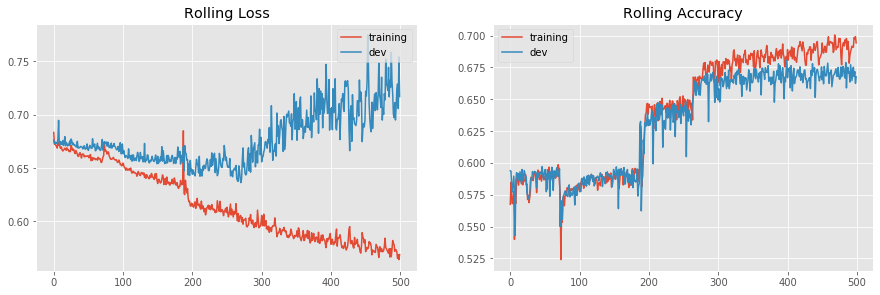

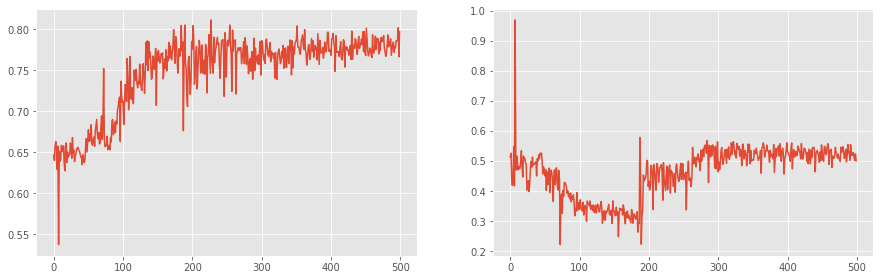

In [120]:
#### RUN MODEL
epochs = 500
model.load_state_dict(init_state)
optimizer.load_state_dict(init_state_opt)
model.to(device)
results = train_net(train_loader,dev_loader,lr_rate)

Epoch: 0 	Training Loss: 0.610951
Epoch: 1 	Training Loss: 0.622308
Epoch: 2 	Training Loss: 0.613131
Epoch: 3 	Training Loss: 0.608873
Epoch: 4 	Training Loss: 0.611121
Epoch: 5 	Training Loss: 0.611727
Epoch: 6 	Training Loss: 0.618484
Epoch: 7 	Training Loss: 0.616167
Epoch: 8 	Training Loss: 0.612821
Epoch: 9 	Training Loss: 0.608014
Epoch: 10 	Training Loss: 0.613490
Epoch: 11 	Training Loss: 0.614206
Epoch: 12 	Training Loss: 0.615566
Epoch: 13 	Training Loss: 0.610815
Epoch: 14 	Training Loss: 0.607292
Epoch: 15 	Training Loss: 0.610810
Epoch: 16 	Training Loss: 0.609949
Epoch: 17 	Training Loss: 0.612860
Epoch: 18 	Training Loss: 0.612217
Epoch: 19 	Training Loss: 0.615462
Epoch: 20 	Training Loss: 0.613304
Epoch: 21 	Training Loss: 0.615534
Epoch: 22 	Training Loss: 0.612467
Epoch: 23 	Training Loss: 0.617161
Epoch: 24 	Training Loss: 0.612236
Epoch: 25 	Training Loss: 0.612942
Epoch: 26 	Training Loss: 0.614413
Epoch: 27 	Training Loss: 0.607981
Epoch: 28 	Training Loss: 0.61

Epoch: 231 	Training Loss: 0.603650
Epoch: 232 	Training Loss: 0.601869
Epoch: 233 	Training Loss: 0.603715
Epoch: 234 	Training Loss: 0.602347
Epoch: 235 	Training Loss: 0.604395
Epoch: 236 	Training Loss: 0.603729
Epoch: 237 	Training Loss: 0.602330
Epoch: 238 	Training Loss: 0.601370
Epoch: 239 	Training Loss: 0.600691
Epoch: 240 	Training Loss: 0.611197
Epoch: 241 	Training Loss: 0.602315
Epoch: 242 	Training Loss: 0.602260
Epoch: 243 	Training Loss: 0.605105
Epoch: 244 	Training Loss: 0.603154
Epoch: 245 	Training Loss: 0.615380
Epoch: 246 	Training Loss: 0.602158
Epoch: 247 	Training Loss: 0.602731
Epoch: 248 	Training Loss: 0.613833
Epoch: 249 	Training Loss: 0.605774
Epoch: 250 	Training Loss: 0.605217
Epoch: 251 	Training Loss: 0.603112
Epoch: 252 	Training Loss: 0.600125
Epoch: 253 	Training Loss: 0.606584
Epoch: 254 	Training Loss: 0.606110
Epoch: 255 	Training Loss: 0.601179
Epoch: 256 	Training Loss: 0.599500
Epoch: 257 	Training Loss: 0.600210
Epoch: 258 	Training Loss: 0

Epoch: 459 	Training Loss: 0.595882
Epoch: 460 	Training Loss: 0.601018
Epoch: 461 	Training Loss: 0.603275
Epoch: 462 	Training Loss: 0.592425
Epoch: 463 	Training Loss: 0.592787
Epoch: 464 	Training Loss: 0.595305
Epoch: 465 	Training Loss: 0.592670
Epoch: 466 	Training Loss: 0.594787
Epoch: 467 	Training Loss: 0.597776
Epoch: 468 	Training Loss: 0.596358
Epoch: 469 	Training Loss: 0.598142
Epoch: 470 	Training Loss: 0.594908
Epoch: 471 	Training Loss: 0.595979
Epoch: 472 	Training Loss: 0.594373
Epoch: 473 	Training Loss: 0.594634
Epoch: 474 	Training Loss: 0.594532
Epoch: 475 	Training Loss: 0.595080
Epoch: 476 	Training Loss: 0.592043
Epoch: 477 	Training Loss: 0.596340
Epoch: 478 	Training Loss: 0.593021
Epoch: 479 	Training Loss: 0.595287
Epoch: 480 	Training Loss: 0.595106
Epoch: 481 	Training Loss: 0.593099
Epoch: 482 	Training Loss: 0.601510
Epoch: 483 	Training Loss: 0.596759
Epoch: 484 	Training Loss: 0.599752
Epoch: 485 	Training Loss: 0.596751
Epoch: 486 	Training Loss: 0

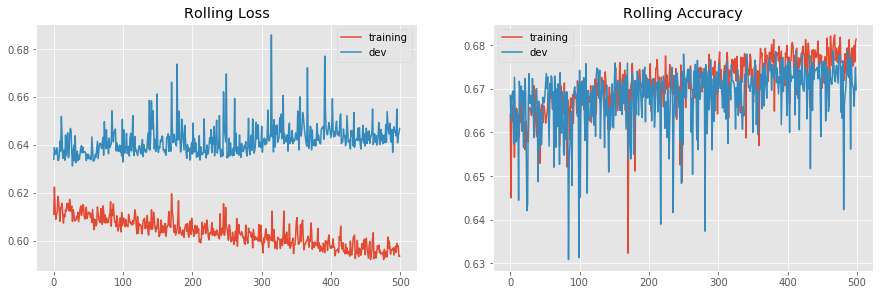

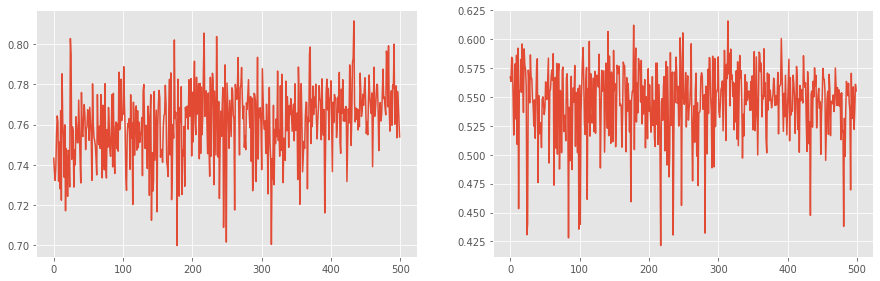

In [118]:
results = train_net(train_loader,dev_loader,lr_rate)

In [ ]:
420
Train Loss:	 0.62915 , 	Test Loss:	 0.66995
Train Accuracy:	 0.65166 , 	Test Accuracy:	 0.6357
Precision:	 0.67342 , 	Recall:	 0.59462

In [108]:
last_model = model

In [ ]:
## save model
outfile = open("model_1024.pkl",'wb')
pickle.dump(last_model, outfile)
outfile.close()

In [ ]:
## model_1 is the best model
loadfile = open("model_1.pkl",'rb')
saved_model = pickle.load(loadfile)
loadfile.close()
test_net(dev_loader, saved_model, torch.nn.BCELoss())

(0.013583977685072031, 0.9649573037790697, 0.9985232543254862, 1.0)

In [ ]:
loadfile = open("model_init.pkl",'rb')
model_init = pickle.load(loadfile)
loadfile.close()

  0%|          | 0/10 [00:00<?, ?it/s]/Users/huangraelene/opt/anaconda3/envs/tnsfl/lib/python3.7/site-packages/torch/nn/modules/loss.py:498: UserWarning: Using a target size (torch.Size([3])) that is different to the input size (torch.Size([3, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)
100%|██████████| 10/10 [00:53<00:00,  5.37s/it]


Train Loss:  0.013925376385699998 , Test Loss:  0.013601134293694578
Train Accuracy:  0.9612101765422078 , Test Accuracy:  0.9620957485465116
Precision:  1.0 , Recall:  1.0


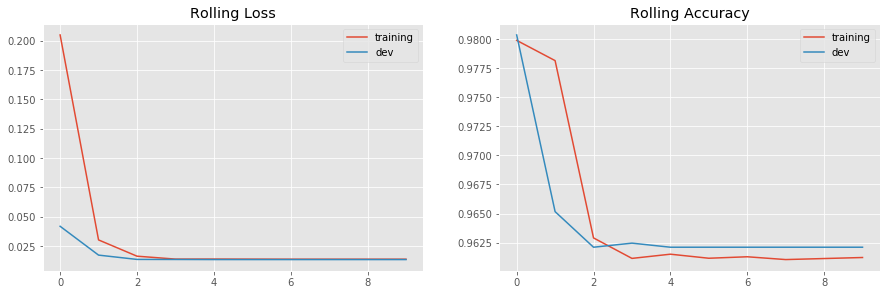

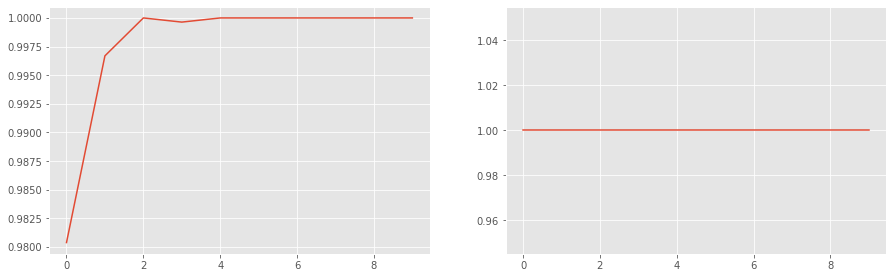

100%|██████████| 10/10 [00:55<00:00,  5.58s/it]


Train Loss:  0.013784325032620066 , Test Loss:  0.014498367940299187
Train Accuracy:  0.961520900974026 , Test Accuracy:  0.9627997819767442
Precision:  0.9992732558139535 , Recall:  1.0


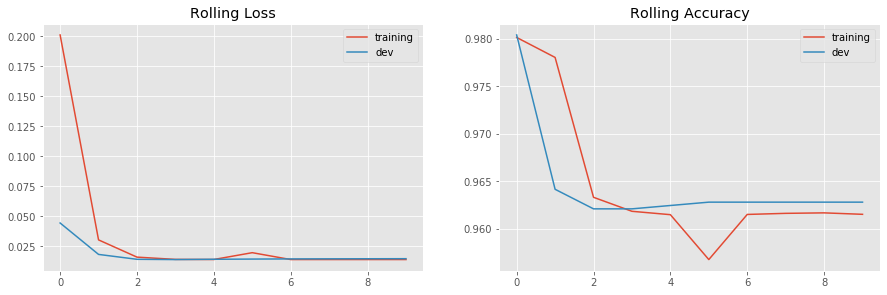

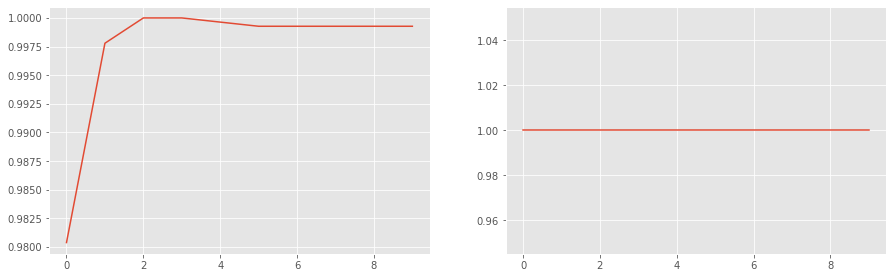

100%|██████████| 10/10 [01:02<00:00,  6.28s/it]


Train Loss:  0.013643661441529027 , Test Loss:  0.013601053983546517
Train Accuracy:  0.9619457690746753 , Test Accuracy:  0.9620957485465116
Precision:  1.0 , Recall:  1.0


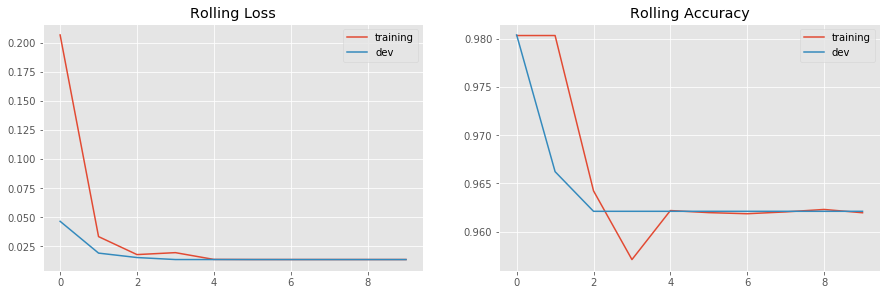

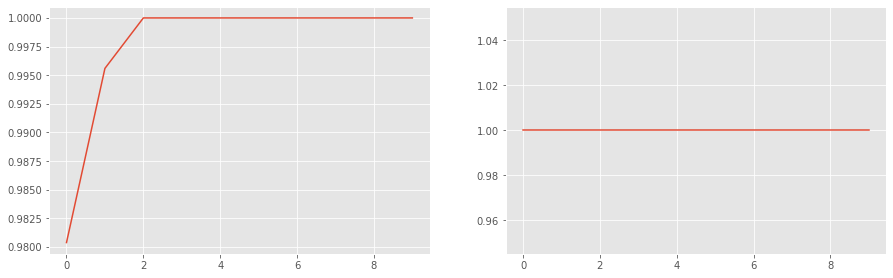

100%|██████████| 10/10 [00:56<00:00,  5.66s/it]


Train Loss:  0.014065557252627793 , Test Loss:  0.014249967757855886
Train Accuracy:  0.9609628652597403 , Test Accuracy:  0.962425054505814
Precision:  0.9996249062265566 , Recall:  1.0


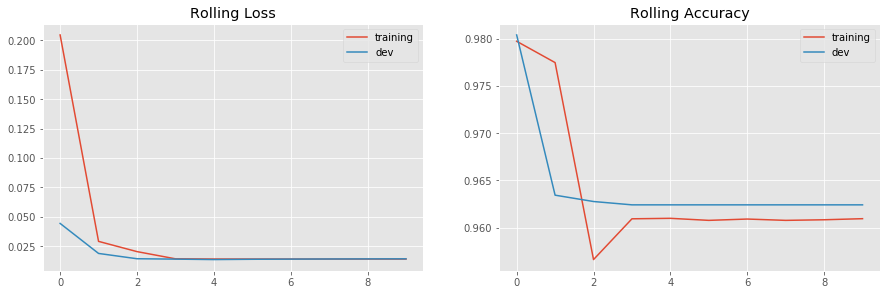

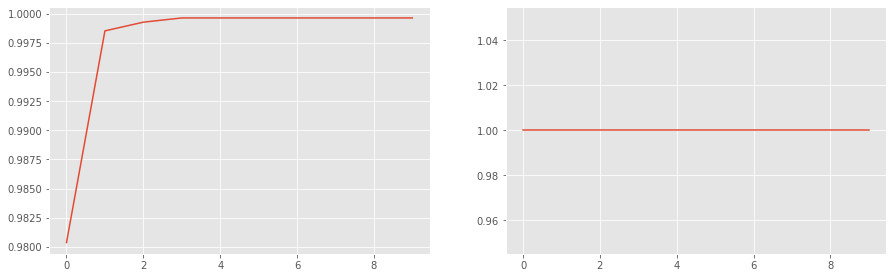

100%|██████████| 10/10 [00:55<00:00,  5.51s/it]


Train Loss:  0.013222004240870553 , Test Loss:  0.014368281549503849
Train Accuracy:  0.9634359780844156 , Test Accuracy:  0.9624477652616279
Precision:  0.9996366279069767 , Recall:  1.0


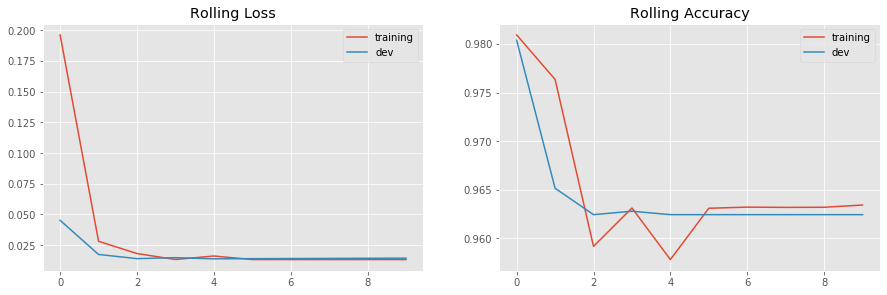

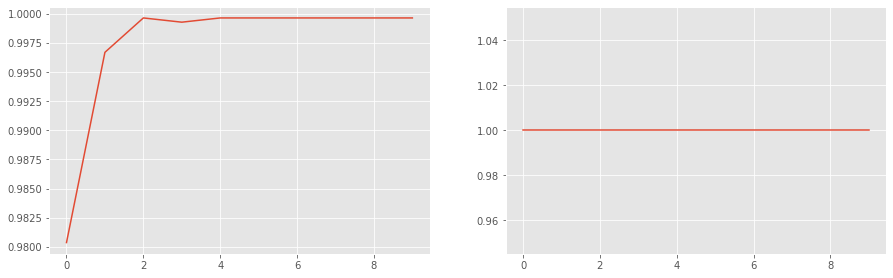

100%|██████████| 10/10 [01:01<00:00,  6.19s/it]


Train Loss:  0.01420654689110242 , Test Loss:  0.013601260678878818
Train Accuracy:  0.9604999492694806 , Test Accuracy:  0.9620957485465116
Precision:  1.0 , Recall:  1.0


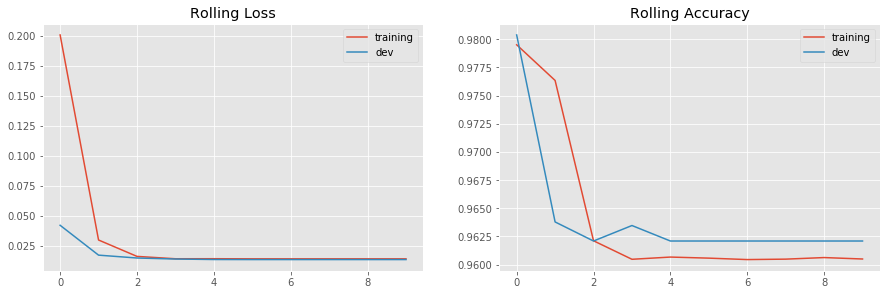

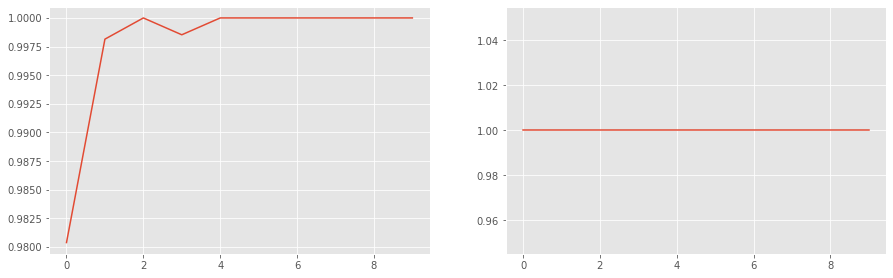

100%|██████████| 10/10 [00:58<00:00,  5.83s/it]


Train Loss:  0.014347694744022834 , Test Loss:  0.01360138194422887
Train Accuracy:  0.9599736201298701 , Test Accuracy:  0.9620957485465116
Precision:  1.0 , Recall:  1.0


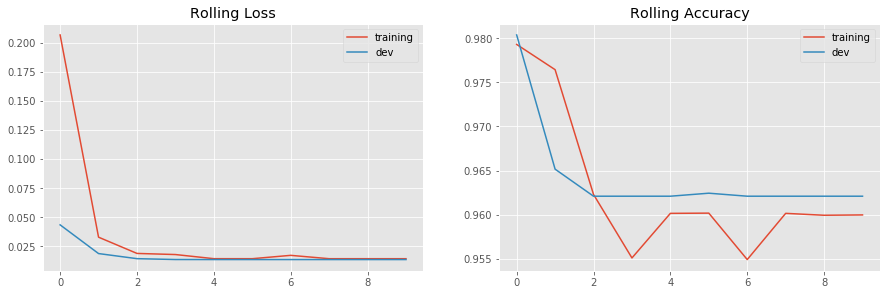

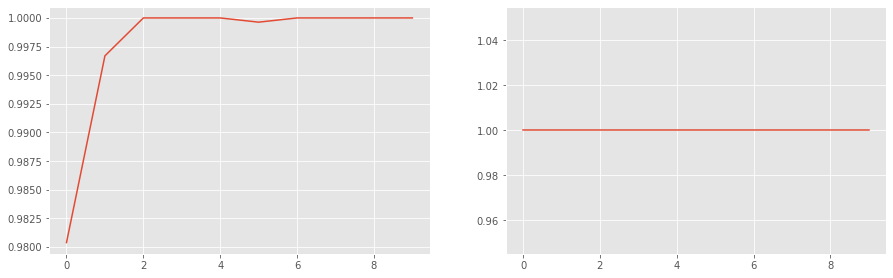

100%|██████████| 10/10 [00:58<00:00,  5.83s/it]


Train Loss:  0.013362392565465094 , Test Loss:  0.013601053896962392
Train Accuracy:  0.9627194094967533 , Test Accuracy:  0.9620957485465116
Precision:  1.0 , Recall:  1.0


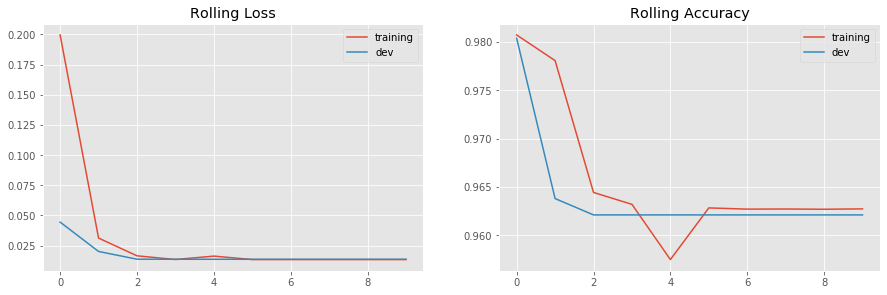

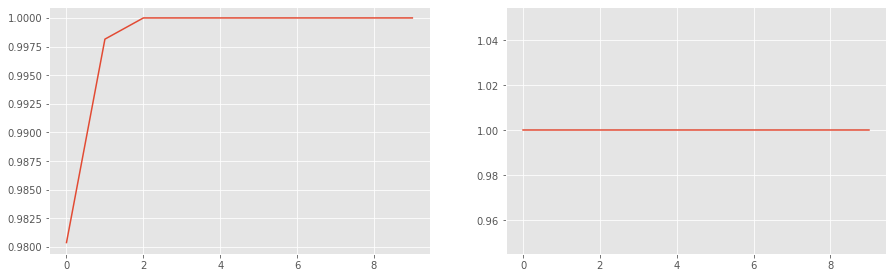

  0%|          | 0/10 [00:00<?, ?it/s]/Users/huangraelene/opt/anaconda3/envs/tnsfl/lib/python3.7/site-packages/torch/nn/modules/loss.py:498: UserWarning: Using a target size (torch.Size([4])) that is different to the input size (torch.Size([4, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)
100%|██████████| 10/10 [00:57<00:00,  5.75s/it]


Train Loss:  0.01378476469192368 , Test Loss:  0.014431673950200908
Train Accuracy:  0.961711140422078 , Test Accuracy:  0.962425054505814
Precision:  0.9996249062265566 , Recall:  1.0


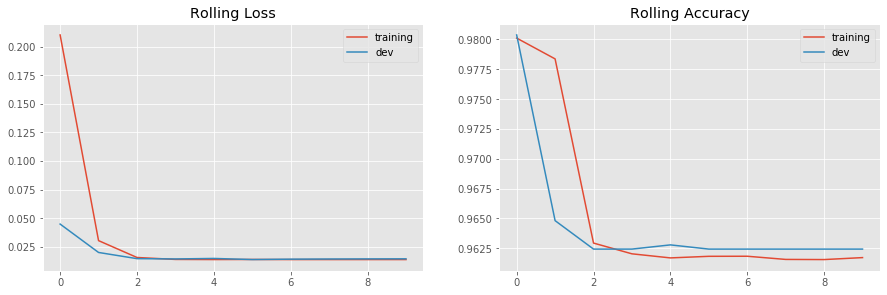

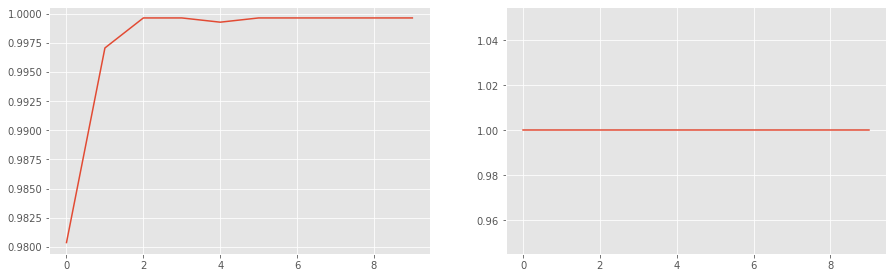

100%|██████████| 10/10 [00:51<00:00,  5.16s/it]


Train Loss:  0.013643774487471012 , Test Loss:  0.01360114166206253
Train Accuracy:  0.9619711343344156 , Test Accuracy:  0.9620957485465116
Precision:  1.0 , Recall:  1.0


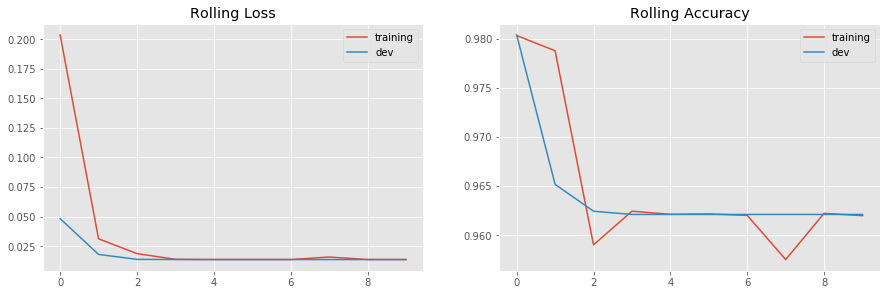

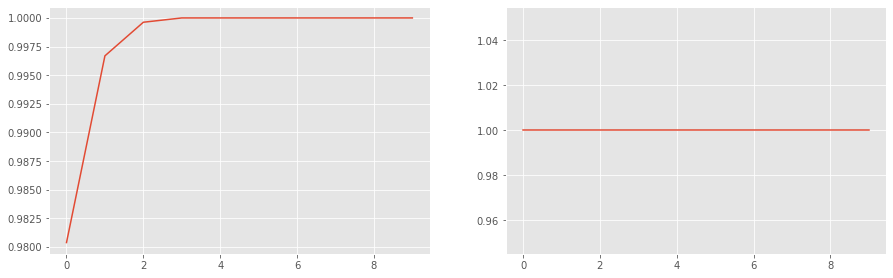

In [ ]:
import copy
from sklearn.model_selection import KFold
kfold = KFold(n_splits=10)
batch_size = 64
cv_results = {}

for fold, (train_index, test_index) in enumerate(kfold.split(x, y)):
    x_train_fold = x[train_index]
    x_test_fold = x[test_index]
    y_train_fold = y[train_index]
    y_test_fold = y[test_index]
    
    train_loader = torch.utils.data.DataLoader(dataset=tuple(zip(x_train_fold,y_train_fold)), batch_size = batch_size, shuffle = True)
    test_loader = torch.utils.data.DataLoader(dataset=tuple(zip(x_test_fold,y_test_fold)), batch_size = batch_size, shuffle = False)
    
    model.load_state_dict(init_state)
    optimizer.load_state_dict(init_state_opt)
    model.to(device)
    
    cv_results[fold] = train_net(train_loader,dev_loader,lr_rate)